# Grokking

In [1]:
import os
from typing import Callable, Dict, List, Literal, Optional, Union, Any, Type, Tuple 
import logging
from dataclasses import dataclass
from pathlib import Path
import time

from tqdm import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pydantic import BaseModel
import wandb

import torch
from torch import nn
from torch import optim
from torch.multiprocessing import Pool, cpu_count
from torch.nn import functional as F
from torch.utils.data import DataLoader

from devinterp.slt.sampler import estimate_rlct
from devinterp.zoo.arithmetic import ModularArithmeticConfig, ModularArithmetic, OperatorLiteral
from devinterp.zoo.transformer import TransformerConfig, Transformer
from devinterp.slt.sampler import estimate_rlct
from devinterp.optim.sgld import SGLD

logging.basicConfig(level=logging.INFO)

sns.set_palette("deep")
sns.set_style("whitegrid")

CHECKPOINTS_PATH = Path("checkpoints/grokking")

if not os.path.exists(CHECKPOINTS_PATH):
    os.makedirs(CHECKPOINTS_PATH)

PRIMARY, SECONDARY, TERTIARY = sns.color_palette("deep")[:3]
PRIMARY_LIGHT, SECONDARY_LIGHT, TERTIARY_LIGHT = sns.color_palette("muted")[:3]

DEVICE = os.environ.get("DEVICE", "cuda:0" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
DEVICE = torch.device(DEVICE)
NUM_CORES = int(os.environ.get("NUM_CORES", 1))

# wandb
PROJECT = os.environ.get("PROJECT", "grokking")
ENTITY = os.environ.get("ENTITY", "devinterp")
# ENTITY = None
USE_WANDB = bool(PROJECT and ENTITY)

DEVICE, NUM_CORES, PROJECT, ENTITY, USE_WANDB

(device(type='mps'), 1, 'grokking', 'devinterp', True)

In [2]:
# Evals

def cross_entropy_last_token(outputs, targets, reduction = "sum"):
    """
    Wrapper around cross entropy loss because we only care about the last number predicted.
    """
    # Only look at predictions of last numbers
    outputs = outputs[:, -1]

    # Compute individual and summed losses for final number
    logprobs = F.log_softmax(outputs.to(torch.float32), dim=-1)
    prediction_logprobs = torch.gather(logprobs, index=targets.unsqueeze(1), dim=-1)

    if reduction == "mean":
        loss = -torch.mean(prediction_logprobs)
    elif reduction == "sum":
        loss = -torch.sum(prediction_logprobs)
    else:
        raise ValueError("Invalid reduction argument.")

    return loss


def make_evals(trainset: ModularArithmetic, testset: ModularArithmetic, device: str):
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=1024, shuffle=True)
    testloader = torch.utils.data.DataLoader(testset, batch_size=1024, shuffle=False)

    def eval_loss_and_acc(model: nn.Module) -> Dict[str, float]:
        model.eval()

        results = {}

        for name, loader in zip(["train", "test"], [trainloader, testloader]):
            total = 0
            correct = 0

            for x, y in loader:
                x = x.to(device)
                y = y.to(device)

                with torch.no_grad():
                    y_hat = model(x)

                total += cross_entropy_last_token(y_hat, y, reduction="sum").item()
                correct += (y_hat[:, -1, :].max(dim=1).indices == y).sum().item()  # argmax doesn't work for device=mps

            results[f"{name}/loss"] = total / len(loader.dataset)
            results[f"{name}/accuracy"] = correct / len(loader.dataset)

        return results

    return eval_loss_and_acc

In [3]:
@dataclass
class Learner:
    config: 'GrokkingConfig'
    model: nn.Module
    dataset: torch.utils.data.Dataset
    loader: torch.utils.data.DataLoader
    optimizer: torch.optim.Optimizer
    evals: Callable[[nn.Module], Dict[str, float]]

class GrokkingConfig(BaseModel):
    data: ModularArithmeticConfig
    model: TransformerConfig
    noise_level: float = 1.
    batch_size: int = 256
    num_steps: int = 25_000
    device: str = "cpu"
    lr: float = 1e-3
    betas: Tuple[float, float] = (0.9, 0.99)
    weight_decay: float = 1e-3

    class Config:
        arbitrary_types_allowed=True

    @property
    def num_training_examples(self):
        return int((self.data.modulus ** 2) * self.data.split)
    
    def create_model(self):
        return self.model.factory()
        
    def create_data(self):
        return self.data.factory_split()

    def create_learner(self):
        model = self.create_model()
        trainset, testset = self.create_data()
        trainloader = torch.utils.data.DataLoader(trainset, batch_size=self.batch_size, shuffle=True)
        evals = make_evals(trainset, testset, self.device)
        optimizer=optim.AdamW(
            model.parameters(),
            lr=self.lr,
            betas=self.betas,
            weight_decay=self.weight_decay,
        )

        learner = Learner(self, model, trainset, trainloader, optimizer, evals)
        return learner

MODULUS = 113

learner_config = GrokkingConfig(
    data=ModularArithmeticConfig(
        operator="/",
        modulus=MODULUS,
        seed=0,
        split=0.4
    ),
    model=TransformerConfig(
        d_vocab = MODULUS + 1,
        d_model=128,
        num_layers=2,
    ),
    lr = 1e-3,
    weight_decay = 0.2,
    betas = (0.9, 0.98),
    device=str(DEVICE),
)
learner = learner_config.create_learner()

In [4]:
def throttle(seconds):
    def decorator(func):
        last_called = 0

        def wrapper(*args, **kwargs):
            nonlocal last_called
            elapsed = time.monotonic() - last_called
            last_called = time.monotonic()

            if elapsed < seconds:
                return func(*args, **kwargs)

        return wrapper

    return decorator

def train(learner, use_wandb=USE_WANDB, num_log_ivl_steps=100, num_lin_ivl_steps=100):
    learner.model.to(learner.config.device)
    learner.model.train()

    evals = []

    if use_wandb:
        wandb.init(project=PROJECT, entity=ENTITY)

    num_steps = learner.config.num_steps
    logging_steps = set(np.linspace(0, num_steps, num_lin_ivl_steps).astype(int)) | set(np.logspace(0, num_steps, num_log_ivl_steps).astype(int))

    def log(step):
        learner.model.eval()
        evals.append({"step": step, **learner.evals(learner.model)})
        # print(yaml.dump(evals[-1]))
        if use_wandb:
            wandb.log(evals[-1], step=step)

        learner.model.train()

    @throttle(1)
    def log_batch_loss(loss, step):
        wandb.log({"batch/loss": loss.item()}, step=step)

    def save_checkpoint(step):
        torch.save(learner.model.state_dict(), CHECKPOINTS_PATH / f"{step}.pt")

    step = -1
    epoch = -1

    pbar = tqdm(
        total=learner.config.num_steps,
        desc=f"Training...",
    )

    while step < learner.config.num_steps:
        torch.manual_seed(step)
        epoch += 1

        for x, y in learner.loader:
            step += 1
            x, y = x.to(learner.config.device), y.to(learner.config.device)
            learner.optimizer.zero_grad()
            y_hat = learner.model(x)
            loss = cross_entropy_last_token(y_hat, y)
            loss.backward()
            learner.optimizer.step()

            if use_wandb:
                log_batch_loss(loss, step)                

            if step in logging_steps:
                log(step=step)
                save_checkpoint(step=step)

            pbar.update(1)

    if pbar:
        pbar.close()

    log(step=step)

    if use_wandb:
        wandb.finish()

    evals_df = pd.DataFrame(evals)
    evals_df.sort_values("step", inplace=True)
    
    return evals_df

In [5]:
train(learner, True)

ERROR:wandb.jupyter:Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: jqhoogland (devinterp). Use `wandb login --relogin` to force relogin


/Users/Jesse/Projects/devinterp/.venv/lib/python3.9/site-packages/numpy/core/function_base.py:298: RuntimeWarning: overflow encountered in power
  return _nx.power(base, y)
/var/folders/pw/6c492xhs4299155z1pvbwt8w0000gn/T/ipykernel_36761/1344494103.py:27: RuntimeWarning: invalid value encountered in cast
  logging_steps = set(np.linspace(0, num_steps, num_lin_ivl_steps).astype(int)) | set(np.logspace(0, num_steps, num_log_ivl_steps).astype(int))
Training...: 25020it [13:53, 30.00it/s]                           


batch/loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁
step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
test/accuracy,▁▁▁▁▁▁▁▁▁▁▁▁▁▂▃▅████████████████████████
test/loss,▃▄▇▇▇▇█▆█▆█▇▅▄▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/accuracy,▁▃██████▇███████████████████████████████
train/loss,█▆▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
batch/loss,6e-05
step,25019
test/accuracy,1.0
test/loss,0.0
train/accuracy,1.0


,step,train/loss,train/accuracy,test/loss,test/accuracy
0,0,4.794228e+00,0.013119,4.799182e+00,0.015009
1,1,4.775462e+00,0.021539,4.789886e+00,0.025189
2,252,3.097716e+00,0.261798,6.459522e+00,0.018794
3,505,5.213807e-01,0.907578,1.085587e+01,0.020230
4,757,8.076529e-02,0.993538,1.433043e+01,0.020752
...,...,...,...,...,...
97,24242,2.155425e-04,1.000000,3.700577e-04,1.000000
98,24494,7.015024e-05,1.000000,1.082348e-04,1.000000
99,24747,4.866764e-06,1.000000,8.068125e-06,1.000000
100,25000,2.830024e-07,1.000000,6.746472e-07,1.000000


In [50]:
def make_rlct_evals(trainset: ModularArithmetic, num_draws=20, num_chains=5, num_cores=NUM_CORES, lr=1e-7, noise_level=1., weight_decay=3e-7, elasticity=1., repeats=5, pbar=False):
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=1024, shuffle=True)
    optimizer_kwargs = dict(
        lr=lr, noise_level=noise_level, weight_decay=weight_decay, elasticity=elasticity, temperature="adaptive", num_samples=len(trainset)
    )

    def eval_rlct(model: nn.Module):
        return estimate_rlct(
            model, 
            trainloader, 
            cross_entropy_last_token, 
            SGLD, 
            optimizer_kwargs, 
            num_draws=num_draws, 
            num_chains=num_chains, 
            num_burnin_steps=0, 
            num_steps_bw_draws=1, 
            cores=num_cores, 
            pbar=pbar,
        )

    def eval_rlct_repeated(model):
        results = {
            f"rlct/{i}": eval_rlct(model).item() for i in range(repeats)
        }
        rlcts = list(results.values())
        results["rlct/mean"] = np.mean(rlcts).item()
        results["rlct/std"] = np.std(rlcts).item()

        return results
    
    return eval_rlct_repeated


def eval_rlcts_at_step(learner: Learner, step: int, num_draws=20, num_chains=5, num_cores=NUM_CORES, lr=1e-7, noise_level=1., weight_decay=3e-7, elasticity=1., repeats=5):
    evals = []
    eval_rlcts = make_rlct_evals(learner.dataset, num_draws=num_draws, num_chains=num_chains, num_cores=num_cores, lr=lr, noise_level=noise_level, weight_decay=weight_decay, elasticity=elasticity, repeats=repeats)

    checkpoint = torch.load(CHECKPOINTS_PATH / f"{step}.pt")
    learner.model.load_state_dict(checkpoint)
    evals.append(eval_rlcts(learner.model))

    return pd.DataFrame(evals)


def eval_rlcts_over_time(learner: Learner, steps: List[int], num_draws=20, num_chains=5, num_cores=NUM_CORES, lr=1e-7, noise_level=1., weight_decay=3e-7, elasticity=1., repeats=5):
    evals = []
    eval_rlcts = make_rlct_evals(learner.dataset, num_draws=num_draws, num_chains=num_chains, num_cores=num_cores, lr=lr, noise_level=noise_level, weight_decay=weight_decay, elasticity=elasticity, repeats=repeats)

    for step in steps:
        checkpoint = torch.load(CHECKPOINTS_PATH / f"{step}.pt")
        learner.model.load_state_dict(checkpoint)
        evals.append(eval_rlcts(learner.model))

    return pd.DataFrame(evals)

## RLCT estimation hyperparameter tuning

In [53]:
from itertools import product
from typing import Iterable

import yaml


def unroll_grid(**hyperparams):
    hyperparams = {k: (v if isinstance(v, list) else [v]) for k, v in hyperparams.items()}

    keys, values = zip(*hyperparams.items())
    combinations = list(product(*values))
    return [dict(zip(keys, c)) for c in combinations]


def generate_rlct_hyperparam_grid_search(model, dataset, **hyperparams):
    grid = unroll_grid(**hyperparams)

    for _hyperparams in grid:
        evals = make_rlct_evals(dataset, pbar=True, **_hyperparams)(model)
        yield _hyperparams, evals


def rlct_hyperparam_grid_search(model, dataset, **hyperparams):
    results = []

    for _hyperparams, evals in generate_rlct_hyperparam_grid_search(model, dataset, **hyperparams):
        results.append({**_hyperparams, **evals})
        print(yaml.dump(results[-1]))

    return pd.DataFrame(results)


grid_search = rlct_hyperparam_grid_search(learner.model, dataset=learner.dataset, lr=[1e-7, 1e-6, 1e-5], num_draws=[10, 30, 100, 300, 1000], noise_level=[0.1, 0.3, 1.], num_chains=1, repeats=5, elasticity=[10., 100., 1000.])

TypeError: estimate_rlct() got multiple values for argument 'criterion'

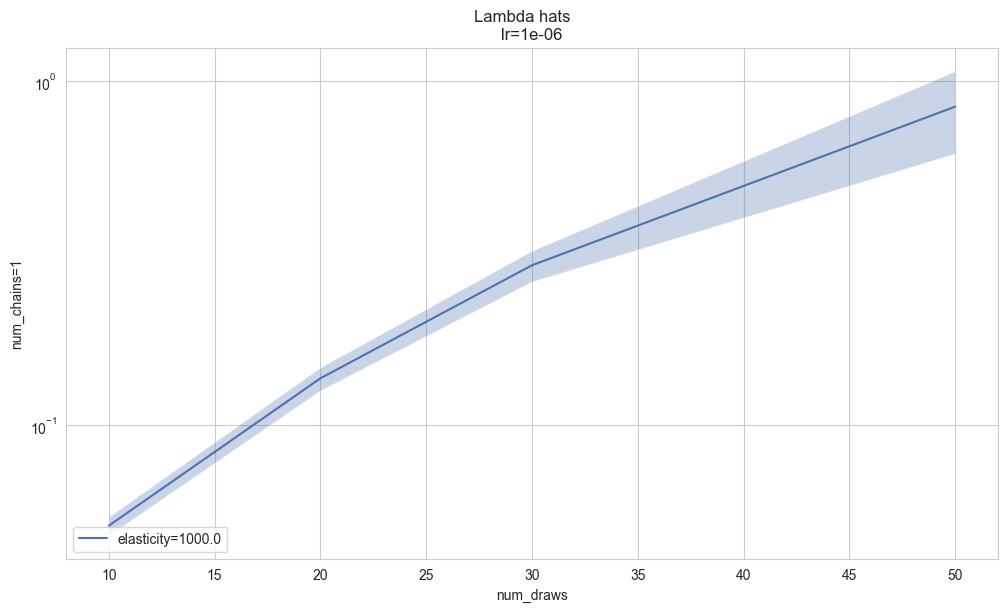

In [48]:
import matplotlib.pyplot as plt

def plot_rlct_grid(df, col_axis: str, row_axis: str, label_axis: str, x_axis: str, title: str, logscale: bool = True, inset=False, figsize=(10, 6)):
    cols = df[col_axis].unique()
    rows = df[row_axis].unique()
    labels = df[label_axis].unique()
    xs = df[x_axis].unique()

    # Define the colors for each w value
    colors = [PRIMARY, SECONDARY, TERTIARY]

    # Create a figure with 3 subplots (one for each gamma)
    fig, axes = plt.subplots(len(rows), len(cols), figsize=figsize)

    if len(rows) == 1 and len(cols) == 1:
        axes = np.array([[axes]])
    elif len(rows) == 1: 
        axes = axes.reshape(1, -1)
    elif len(cols) == 1:
        axes = axes.reshape(-1, 1)

    fig.suptitle(title)
    fig.tight_layout()

    # Iterate through the unique gammas
    for i, col in enumerate(cols):
        for j, row in enumerate(rows):
            axes[j, 0].set_ylabel(f"{row_axis}={row}")
            axes[0, i].set_title(f"{col_axis}={col}")
            axes[-1, i].set_xlabel(x_axis)

            ax = axes[j, i]

            for k, label in enumerate(labels):
                data = df[(df[col_axis] == col) & (df[label_axis] == label) & (df[row_axis] == row)]
                color = colors[k]
                
                rlct_mean = data["rlct/mean"]
                rlct_std = data["rlct/std"]

                # Plot the training error against the number of steps
                ax.plot(data[x_axis], rlct_mean, color=color, label=f'{label_axis}={label}')
                ax.fill_between(xs, rlct_mean-rlct_std, rlct_mean+rlct_std, alpha=0.3)

            if logscale:
                ax.set_yscale('log')
                # ax_inset.set_xscale('log')
                # ax.set_xscale('log')

            ax.set_title(f'{col_axis}={col}')
            ax.legend(loc='lower left') 

    plt.show()

plot_rlct_grid(grid_search, col_axis="lr", row_axis="num_chains", x_axis="num_draws", label_axis="elasticity", title="Lambda hats")

In [ ]:
checkpoint_steps = list(map(lambda filename: int(str(filename).split("/")[-1].split(".")[0]), CHECKPOINTS_PATH.glob("*.pt")))
print(checkpoint_steps)
